# ASR Assignment 2022-23
# Modified by s2047210 s2526475

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [3]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math
import numpy as np
from scipy.special import logsumexp, softmax

from subprocess import check_call
from IPython.display import Image


In [4]:

# ... (add your code to create WFSTs and Viterbi Decoder)
fix_pron = False
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            if fix_pron:
                try:
                    lex[line[0]].append(line[1:])
                except KeyError:
                    lex[line[0]] = [line[1:]]# first field the word, the rest is the phones
                
            else:
                lex[line[0]] = [line[1:]] # overdrive first pronunciation of 'a' and 'the', need to modify generate symbol table and generate word seq wfst

    return lex



In [5]:
def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for i in range(5):
        state_table.add_symbol(f'sil_{i+1}')
    
    # need to add sil into tables

    for word, pron  in lexicon.items():
        
        word_table.add_symbol(word)
        for phones in pron:
            for p in phones: # for each phone

                phone_table.add_symbol(p)
                for i in range(1,n+1): # for each state 1 to n
                    state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table

lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)
lex

{'a': [['ey']],
 'of': [['ah', 'v']],
 'peck': [['p', 'eh', 'k']],
 'peppers': [['p', 'eh', 'p', 'er', 'z']],
 'peter': [['p', 'iy', 't', 'er']],
 'picked': [['p', 'ih', 'k', 't']],
 'pickled': [['p', 'ih', 'k', 'ah', 'l', 'd']],
 'piper': [['p', 'ay', 'p', 'er']],
 'the': [['dh', 'iy']],
 "where's": [['w', 'eh', 'r', 'z']]}

In [6]:
class MyViterbiDecoder:
    
    NLL_ZERO = 1e100  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name, prun, k, p, tau):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.prun = prun

        # for pruning experiments
        self.prun = prun
        self.k = k
        self.p = p
        self.tau = tau
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        self.forward_count = 0

        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)      


        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

                    self.forward_count += 1

    
    def forward_step(self, t):
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []

                        self.forward_count += 1
    
    def top_k_pruning(self, t):
        k = self.k 
        kth_best = sorted(self.V[t])[k-1] # neg log so sort from small to large
        for i in self.f.states():
            if self.NLL_ZERO > self.V[t][i] > kth_best:
                self.V[t][i] = self.NLL_ZERO


    def top_p_pruning(self, t): # top-p with temperature
        # this should only be done after a certain time step
        # at the first few time steps, there are very few possible paths, knock them out can harm our system A LOT
        # also the computation seems take long, and hyperparameters need to be tuned carefully
        
        # in short, to get good paths, if we don't want to be bother by distribution, 
        # we need to maintain a few paths (n around 15 i guess) at all time
        # or we risk a lot at some time, becuase the distribution change along decoding step
        # top-k is a more stable method, and the computation is more straightforward - time-saving
        # top-p is quite prone to risk of knocking out potentially good path
        

        p = self.p
        tau = self.tau
        if t > 10: # only do pruning after t > n, tihs can be tuned as well
            # get a smoothed neg logs
            smoo_neg_logs = np.zeros(len(self.V[t]))
            for i in range(len(self.V[t])):
                if self.V[t][i] < self.NLL_ZERO:
                    smoo_neg_logs[i] += self.V[t][i]/tau
                else:
                    smoo_neg_logs[i] += self.V[t][i]
            
            sm_probs = softmax(-smoo_neg_logs) # turn smoothed neg logs into probability distribution

            sorted_neg_logs = sorted(self.V[t]) # sorted_logs store possible neg log scores at time t from small to large
            sorted_probs = sorted(sm_probs, reverse=True) # sort prob from large to small

            for i in range(len(sorted_probs)):
                prob_sum = sum(sorted_probs[:i+1])
                if prob_sum - p > -1e-10: # p is the threshold
                    last_candidate = sorted_neg_logs[i] # but store the raw neg log
                    break

            for i in self.f.states():
                if last_candidate < self.V[t][i]: 
                    if self.V[t][i] != self.NLL_ZERO:
                        self.V[t][i] = self.NLL_ZERO 
                        
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight

        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            if self.prun == 'top-k': 
                self.top_k_pruning(t) 
            if self.prun == 'top-p':
                self.top_p_pruning(t)
            t += 1
        self.finalise_decoding()
        return
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)
    
    def compute_memory(self):
        nstate = 0
        narc = 0
        for state in self.f.states():
            nstate += 1
            for arc in self.f.arcs(state):
                narc += 1
        return nstate, narc
    

In [25]:
# statistics of transcriptions

uni_count = {}
final_count = {}
for txt_file in glob.glob('/group/teaching/asr/labs/recordings/*.txt'):
    with open(txt_file) as f:
        for line in f:
            for i in range(len(line.split())):
                word = line.split()[i]
                try:
                    uni_count[word] += 1
                except KeyError:
                    uni_count[word] = 1

                if i == len(line.split()) - 1:
                    try:
                        final_count[word] += 1
                    except KeyError:
                        final_count[word] = 1

print(uni_count)
print(final_count)

# normalise counts to probabilities

def normalise_counts(count):
    # count is a dictionary
    normalised = {}
    total = sum(count.values())
    for word in count.keys():
        normalised[word] = count[word]/total
    return normalised

uni_probs = normalise_counts(uni_count)

# method b # use this in bigram grammar
final_probs = {}
for word, count in uni_count.items():
    try:
        final_probs[word] = final_count[word]/uni_count[word] 
    except KeyError:
        pass

# method a
final_probs = normalise_counts(final_count) 
# sum(final_probs.values())


{'peter': 338, 'piper': 289, 'picked': 286, 'a': 138, 'peck': 264, 'of': 246, 'pickled': 285, 'peppers': 321, "where's": 118, 'the': 137}
{'picked': 98, 'peppers': 119, 'piper': 37, 'peter': 28, 'peck': 21, 'pickled': 19, 'of': 5, "where's": 2}


In [8]:


def generate_phone_wfst(f, start_state, phone, n, word, last_phone, self_loop_p=0.1, final_p=False):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMM
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    # print(phone)
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        sl_weight = fst.Weight('log', -math.log(self_loop_p))  # weight for self-loop
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
#         if i == n:
#             out_label = phone_table.find(phone)
#         else:
#             out_label = 0   # output empty <eps> label
        
        out_label = 0
            
        next_state = f.add_state()

        if last_phone and i == n:  # add word to the output if last state
            out_label = word_table.find(word)

            if final_p:
                try:
                    final_prob = final_probs[word] # end probability retrieved from text file
                    final_weight = fst.Weight('log', -math.log(final_prob))
                    f.set_final(next_state, final_weight)
                except KeyError:
                    pass
            else:
                f.set_final(next_state)
            
        next_weight = fst.Weight('log', -math.log(1-self_loop_p)) # weight to next state
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        current_state = next_state
        
    return current_state


In [9]:
def generate_silence_wfst(f, start_state, type='l_to_r', self_loop_p=0.1): # just in case if want to test other typology
    """
    Generate a WFST representating an 5-state silence HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        type (str): what typology to use, default to be left-to-right
        
    Returns:
        the final state of the FST
        
    """
    current_state = start_state
    for i in range(5):
        in_label = state_table.find(f'sil_{i+1}')
        
        sl_weight = fst.Weight('log', -math.log(self_loop_p))  # weight for self-loop
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
    
        next_state = f.add_state()
        next_weight = fst.Weight('log', -math.log(1-self_loop_p)) # weight to next state
        f.add_arc(current_state, fst.Arc(in_label, 0, next_weight, next_state))
        current_state = next_state
        
    f.set_final(current_state)
    
    return current_state
        
        

In [10]:
def generate_word_sequence_recognition_wfst(n, uni_lambda, silence, self_loop=0.1, final=False):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    f = fst.Fst('log')
    
    uni_weight = fst.Weight('log', -math.log(1)) # default unigram weight - can be changed according to uni prob
    other_weight = fst.Weight('log', -math.log(1)) # prob = 1, not going to change
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    # f.set_final(start_state)
    
    for word, pron in lex.items():
        for phones in pron:
            current_state = f.add_state()
            if uni_lambda:
                uni_prob = uni_probs[word]
                uni_weight = fst.Weight('log', -math.log(uni_lambda*uni_prob/len(pron))) # average uni_prob might not be the best choice tho
            # else use default weight
            f.add_arc(start_state, fst.Arc(0, 0, uni_weight, current_state))

            for i in range(len(phones)):
                if i == len(phones)-1:
                    last = True
                else:
                    last = False
                current_state = generate_phone_wfst(f, current_state, phones[i], n, word, last, self_loop_p=self_loop, final_p=final)
            # note: new current_state is now set to the final state of the previous phone WFST

            f.add_arc(current_state, fst.Arc(0, 0, other_weight, start_state)) # back to start weight always 1
        
    # generate silence

    if silence:
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0, other_weight, current_state)) # default enter weight
        current_state = generate_silence_wfst(f, current_state, type='l_to_r', self_loop_p=self_loop) # not necessarily the best choice
        f.add_arc(current_state, fst.Arc(0, 0, other_weight, start_state)) # no need to apply lambda since log(1) = 0
    
        
    return f



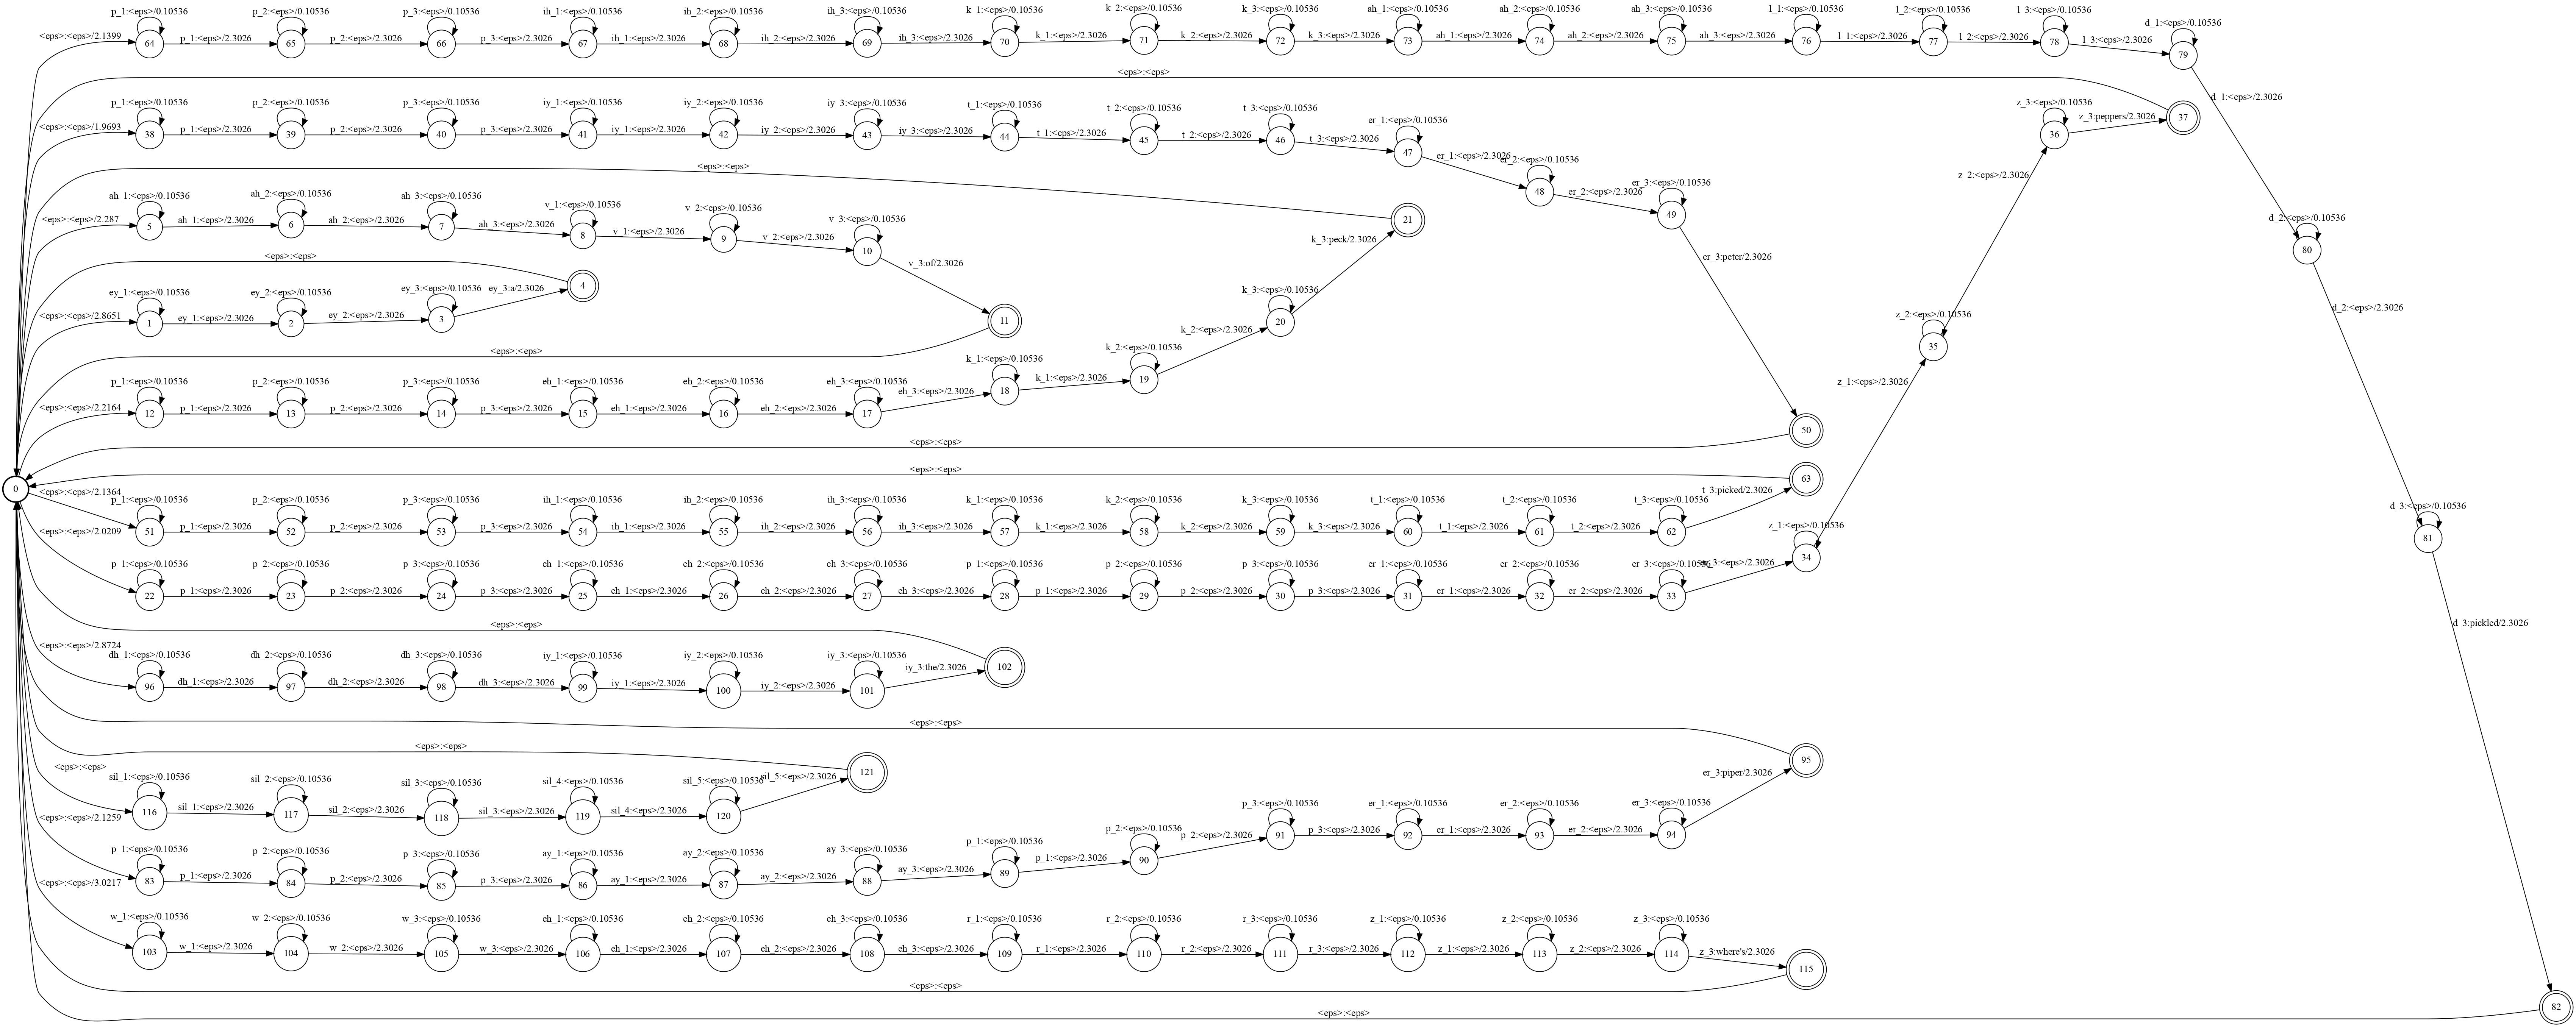

In [11]:
test_f = generate_word_sequence_recognition_wfst(3, 1, True, 0.9)
test_f.set_input_symbols(state_table)
test_f.set_output_symbols(word_table)
# test_f = fst.determinize(test_f)
# test_f.rmepsilon()
# test_f = fst.push(test_f, push_weights=True, push_labels=False)

test_f.draw('tmp.dot' ,portrait=True)
check_call(['dot', '-Tpng', '-Gdpi=800', 'tmp.dot', '-o' ,'tmp.png'])
Image(filename='tmp.png')

In [12]:
# count bigram freq from all transcription
bi_count = {}
first_count = {}
for txt_file in glob.glob('/group/teaching/asr/labs/recordings/*.txt'):
    with open(txt_file) as f:
        for line in f:
            words = line.split()
            words = ['BOS']+words+['EOS']
            for i in range(len(words)-1):
                if i == 1:
                    try:
                        first_count[words[i]] += 1
                    except KeyError:
                        first_count[words[i]] = 1
                try:
                    bi_count[f'{words[i]}-{words[i+1]}'] += 1
                except KeyError:
                    bi_count[f'{words[i]}-{words[i+1]}'] = 1

# print(bi_count)

# bi_probs= normalise_counts(bi_counts)
first_probs = normalise_counts(first_count)
bi_probs = {}
for bigram, count in bi_count.items():
    # print(bigram)
    try:
        bi_probs[bigram] = bi_count[bigram]/uni_count[bigram.split('-')[0]] 
    except KeyError:
        pass
print(first_probs, '\n', final_probs, '\n', bi_probs)

{'peter': 0.3677811550151976, 'a': 0.07598784194528875, "where's": 0.1762917933130699, 'piper': 0.1033434650455927, 'picked': 0.030395136778115502, 'pickled': 0.0851063829787234, 'peppers': 0.0364741641337386, 'of': 0.0121580547112462, 'peck': 0.060790273556231005, 'the': 0.05167173252279635} 
 {'picked': 0.2978723404255319, 'peppers': 0.3617021276595745, 'piper': 0.11246200607902736, 'peter': 0.0851063829787234, 'peck': 0.06382978723404255, 'pickled': 0.057750759878419454, 'of': 0.015197568389057751, "where's": 0.0060790273556231} 
 {'peter-piper': 0.5384615384615384, 'piper-picked': 0.5501730103806228, 'picked-a': 0.2972027972027972, 'a-peck': 0.7608695652173914, 'peck-of': 0.7083333333333334, 'of-pickled': 0.6219512195121951, 'pickled-peppers': 0.6947368421052632, "peppers-where's": 0.09968847352024922, "where's-the": 0.6864406779661016, 'the-peck': 0.6861313868613139, 'peppers-peter': 0.24922118380062305, 'picked-EOS': 0.34265734265734266, 'peter-picked': 0.17751479289940827, 'pepp

In [13]:
# bigram grammar

def generate_G_wfst(words, bi_probs, first_probs, bi_lambda):
    """ Generate a grammar WFST that accepts any sequence of words for words in a sentence.
        The bigrams not present in the sentence have a cost of 1, while those present have a cost of 0. 
        Args:
            wseq (str): the sentence to use
        Returns:
            W (fst.Fst()): the grammar WFST """
    
    G = fst.Fst('log')
    start_state = G.add_state()
    G.set_start(start_state)
    
    mono_state = {}
    
    # lexicon = lex.keys()
    # generate valid bigrams
    # valid_bigrams = []
    # for i in range(len(words)-1):
    #     valid_bigrams.append(words[i]+'-'+words[i+1])
    
    for w in words: # string or lexicon? lexicon in the second solution
        if not mono_state:
            current_state = G.add_state()
            mono_state[w] = current_state
        if w in mono_state:
            current_state = mono_state[w]
        

        # Your code here

        weight = fst.Weight('log', -math.log(first_probs[w] * bi_lambda))
        G.add_arc(start_state, fst.Arc(word_table.find(w), word_table.find(w), weight, current_state))
        
        for next_w in words:
            if next_w == w:
                next_state = current_state
            elif next_w in mono_state:
                next_state = mono_state[next_w]
            else:
                next_state = G.add_state()
                mono_state[next_w]=next_state
                
            G.set_final(next_state)
            
            bigram = f'{w}-{next_w}'
            if bigram in bi_probs:
                weight = fst.Weight('log', -math.log(bi_probs[bigram] * bi_lambda))
                G.add_arc(current_state, fst.Arc(word_table.find(next_w), word_table.find(next_w), weight, next_state))
            else:
                weight = fst.Weight('log', -math.log(1e-100))
                G.add_arc(current_state, fst.Arc(word_table.find(next_w), word_table.find(next_w), weight, next_state))
                
        
    # print(mono_state)
    
    # G.set_final(start_state) # ??
        
    G.set_input_symbols(word_table)
    G.set_output_symbols(word_table)  
 
    return G

# just to inspect
word = "peter piper".split()
# peter piper picked a peck of pickled peppers where's the
test_G = generate_G_wfst(word, bi_probs, first_probs, 1)

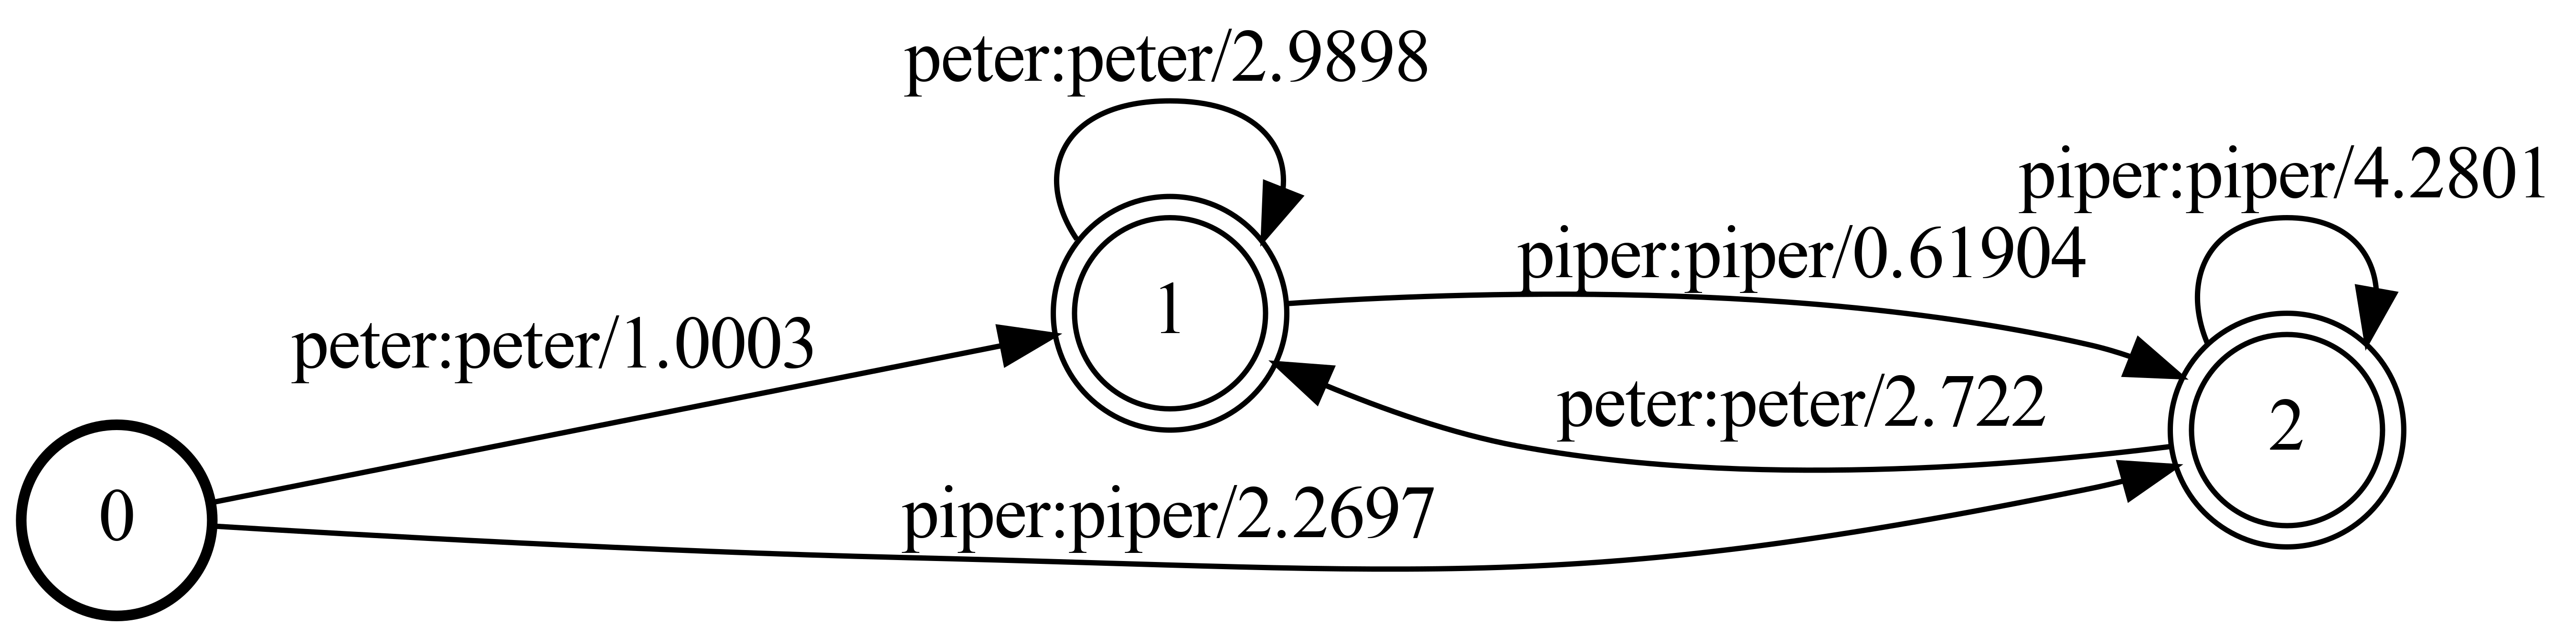

In [14]:
# test_G  = fst.push(test_G, push_weights=True, push_labels=False)
test_G 
test_G.draw('tmp.dot' ,portrait=True)
check_call(['dot', '-Tpng', '-Gdpi=800', 'tmp.dot', '-o' ,'tmp.png'])
Image(filename='tmp.png')

In [15]:
from random import seed
from random import sample

# seed random number generator
seed(1)

# prepare a sequence
dev_set = sample(range(329), 66)

In [22]:
def create_wfst():
    
    # task 2 settings
    self_loop_p = 0.9 # default = 0.1, shared among phones and silence, can change for experiments, [0.1, 0.3, 0.5, 0.7, 0.9]
    final_p = True # whether implement final probability
    silence = True
    unigram_lambda = 0 # interpolation weight
    print('---Task 2 Variables---')
    print('Pronunciation-lexicon model self-loop ', self_loop_p)
    print('Implement final probabilities: ', final_p)
    print('unigram interpolation weight: ', unigram_lambda)
    print('Add silence: ', silence)
    print()
    
    f = generate_word_sequence_recognition_wfst(3, unigram_lambda, silence, self_loop=self_loop_p, final=final_p)
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)
    
    # task 4 settings
    tree = True
    look_ahead = False # not tested
    print('---Task 4 Variables---')
    print('Tree structure: ', tree)
    print('Look-ahead: ', look_ahead)

    bigram_lambda = 1  
    print('bigram interpolation weight: ', bigram_lambda)
    print()
                         
    if bigram_lambda:

        if 1-sum(final_probs.values()) >= 0:
            raise ValueError('Are you using final probabilities from method a?')
        
        word = "peter piper picked a peck of pickled peppers where's the".split()
        # peter piper picked a peck of pickled peppers where's the
        G = generate_G_wfst(word, bi_probs, first_probs, bigram_lambda)
        G.arcsort(sort_type='olabel')

        if look_ahead: # weight push?? not working well
            G = fst.push(G, push_weights=True, push_labels=False)
            
        f = fst.compose(f, G)
    
    if tree:
        f = fst.determinize(f)
        f.rmepsilon()
    
    
    return f

In [26]:
from timeit import default_timer as timer

def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

start = timer()
f = create_wfst()
end = timer()
print(f'wfst created in: {end-start}s \n')

# task 3 settings
print('---Task 3 Variables---')
prun = 'top-k' # 'top-k' or 'top-p'
k = 12
p = 0.9
tau = 60

# it is hard to find the right p, ideally p should be dynamic, depending on the shape of distribution at t
# try tau = 1 for no temperature. The distribution will be very skewed and not working for top-p sampling at all
# p=0.6, tau = 50; p = 0.8, tau = 30; p = 0.9, tau = 15 - good combinations, but can take longer than top-k

print('Decoder pruning method: ', prun if prun else 'no pruning')
if prun == 'top-k':
    print('Using k =', k)
if prun == 'top-p':
    print(f'Using p = {p}, temperature = {tau}')
print()

total_decode_cost = 0
total_backtrace_cost = 0
total_forward_frame = 0

sub_count = 0
del_count = 0
ins_count = 0
total_count = 0


# for num in dev_set:    # for devset tuning
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'): # for evaluation
                                                                           # audio files
    # wav_file = f'/group/teaching/asr/labs/recordings/{num:04}.wav' # for devset tuning
    decoder = MyViterbiDecoder(f, wav_file, prun=prun, k=k, p=p, tau=tau) # pruning method
    print(wav_file)
    print(f'Memory required: {decoder.compute_memory()}') # state, arc

    start = timer()
    decoder.decode()
    end = timer()
    decode_cost = end-start
    # print(f'Decode costs: {decode_cost}s')
    total_decode_cost += decode_cost

    start = timer()
    (state_path, words) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                               # to return the words along the best path
    end = timer()
    backtrace_cost = end-start
    # print(f'Backtrace costs: {backtrace_cost}s')
    total_backtrace_cost += backtrace_cost

    # print(f'Count of forward computations: {decoder.forward_count}')
    total_forward_frame += decoder.forward_count/decoder.om.observation_length()

    print('Prediction: ', words)                               
    transcription = read_transcription(wav_file)
    print('transcription: ', transcription)
    nsub, ndel, nins = wer.compute_alignment_errors(transcription, words)
    sub_count+=nsub
    del_count+=ndel
    ins_count+=nins
    word_count = len(transcription.split())
    total_count+=word_count

    
    # print((nsub, ndel, nins), word_count)     # you'll need to accumulate these to produce an overall Word Error Rate
    print('\n')

print(f'Overall WER = ({sub_count} sub + {del_count} del + {ins_count} ins)/ {total_count} words  = {(sub_count+del_count+ins_count)/total_count}')
print(f'Total decode cost: {total_decode_cost}s')
print(f'Total backtrace cost: {total_backtrace_cost}s')
print(f'Overall average forward per frame: ', total_forward_frame/329) # time affected by device performance, forward count not

    

---Task 2 Variables---
Pronunciation-lexicon model self-loop  0.9
Implement final probabilities:  True
unigram interpolation weight:  0
Add silence:  True

---Task 4 Variables---
Tree structure:  True
Look-ahead:  False
bigram interpolation weight:  1



ValueError: Are you using final probabilities from method a?